In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.0.4
1.1.0


In [90]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [3]:
sess = tf.Session()
K.set_session(sess)

In [4]:
print(K.image_data_format())

channels_last


In [5]:
from collections import Counter
def get_counter(dirpath):
    ann_dirpath = join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = join(ann_dirpath, filename)
        description = json.load(open(json_filepath, 'r'))['description']
        lens.append(len(description))
        letters += description
    print('Plate lengths:', Counter(lens))
    return Counter(letters)
c_train = get_counter('/data/001/train/')
c_val = get_counter('/data/001/train/')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
print(len(letters_train), len(letters_val), len(letters_val & letters_train))
letters = sorted(list(letters_train))
print(' '.join(letters))

Plate lengths: Counter({8: 10788})
Plate lengths: Counter({8: 10788})
22 22 22
0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


In [6]:
OUTPUT_DIR = 'image_ocr'

In [8]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext == '.png':
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                description = json.load(open(json_filepath, 'r'))['description']
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [9]:
tiger = TextImageGenerator('/data/001/val', 128, 64, 8, 4)
tiger.build_data()

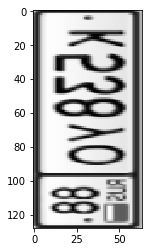

[ 15.   5.   3.   8.  21.  17.   8.   8.]
[ 30.]
[ 8.]


In [123]:
for inp, out in tiger.next_batch():
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    plt.imshow(img, cmap='gray')
    plt.show()
    print(inp['the_labels'][0])
    print(inp['input_length'][0])
    print(inp['label_length'][0])
    #print(inp['source_str'][0])
    break

In [11]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(run_name, start_epoch, stop_epoch, img_w, load=False):
    # Input Parameters
    img_h = 64

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('/data/001/train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('/data/001/val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        if start_epoch > 0:
            weight_file = os.path.join(OUTPUT_DIR, os.path.join(run_name, 'weights%02d.h5' % (start_epoch - 1)))
            model.load_weights(weight_file)
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=stop_epoch, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n,
                            initial_epoch=start_epoch)

    return model

In [12]:
run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
#model = train(run_name, 0, 1, 128)
model = train(run_name, 0, 1, 128, load=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 128, 64, 1)    0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 128, 64, 16)   160         the_input[0][0]                  
____________________________________________________________________________________________________
max1 (MaxPooling2D)              (None, 64, 32, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Conv2D)                   (None, 64, 32, 16)    2320        max1[0][0]                       
___________________________________________________________________________________________

In [13]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

In [29]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

Pred: O482AO75
True: O482AO75


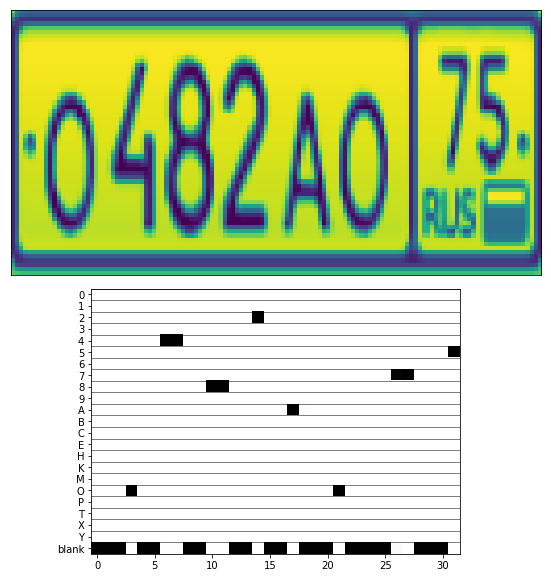

Pred: B624HM70
True: B624HM70


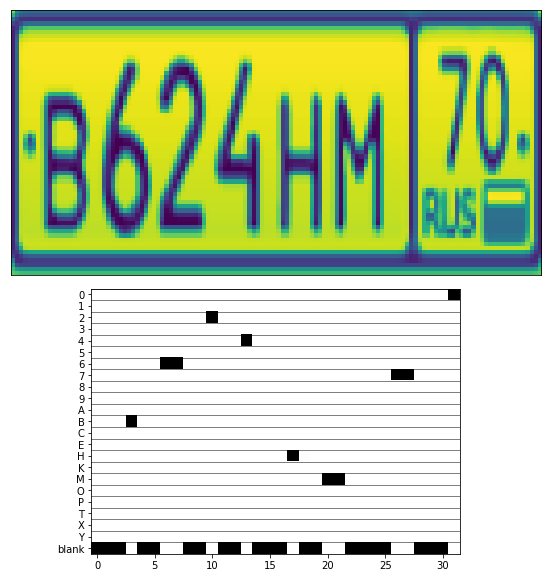

Pred: C076AK20
True: C076AK20


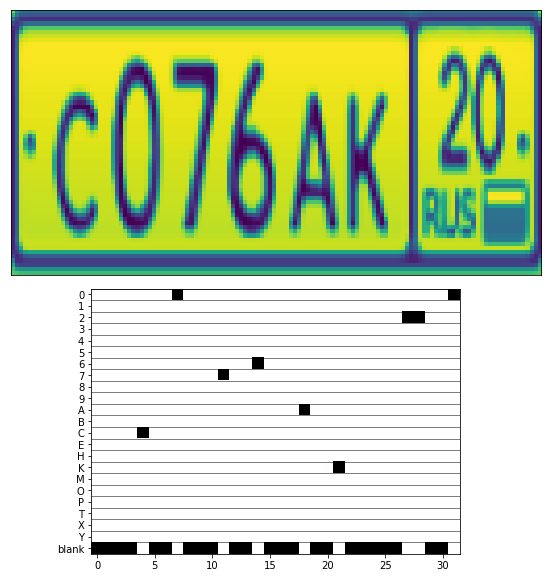

Pred: P203EO52
True: P203EO52


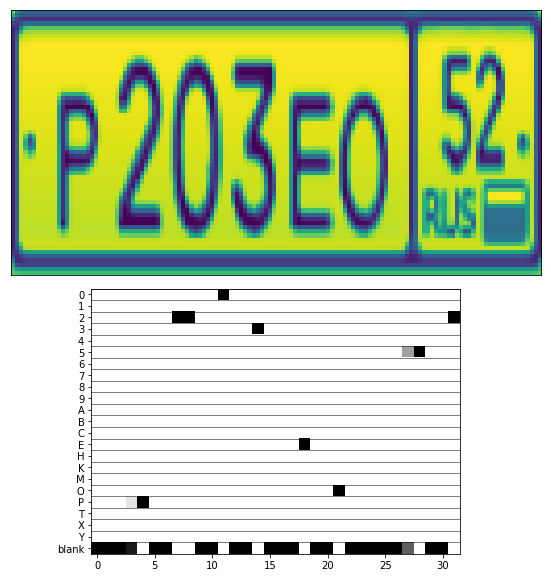

Pred: H256TM89
True: H256TM89


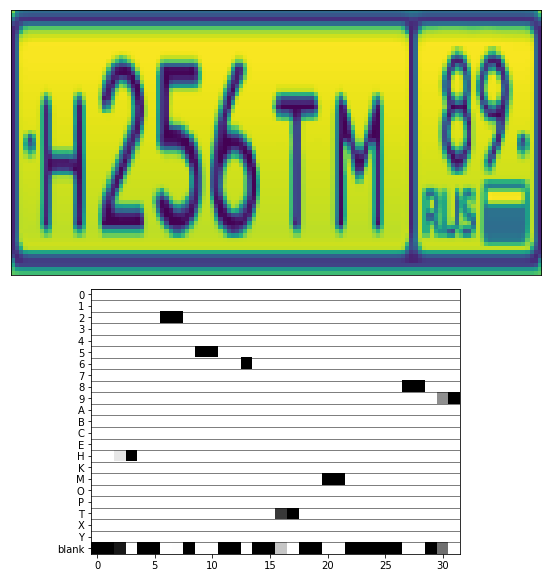

Pred: A504MH55
True: A504MH55


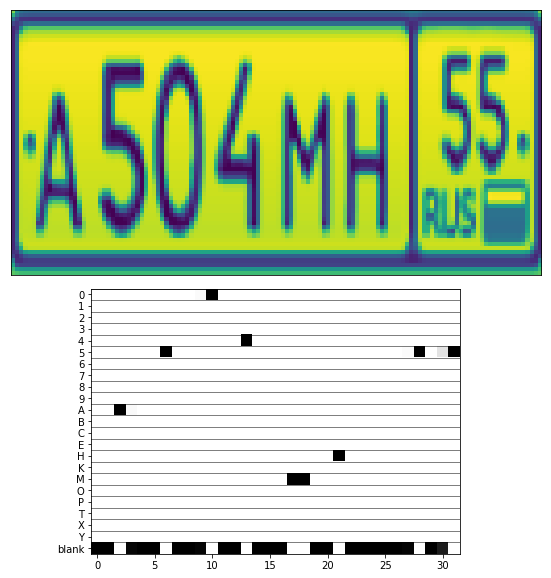

Pred: K125TX76
True: K125TX76


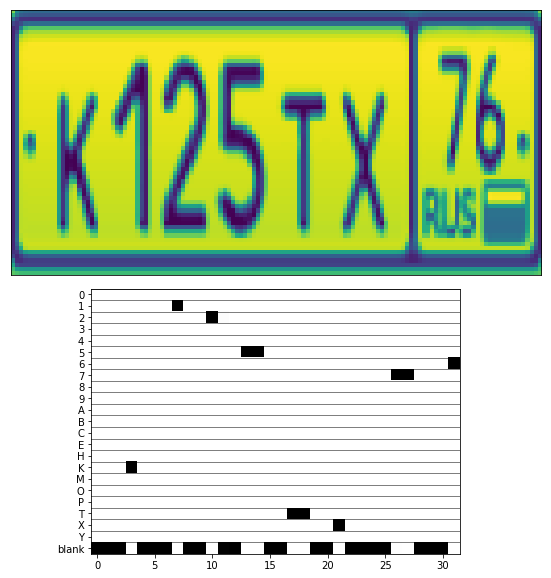

Pred: M504EC51
True: M504EC51


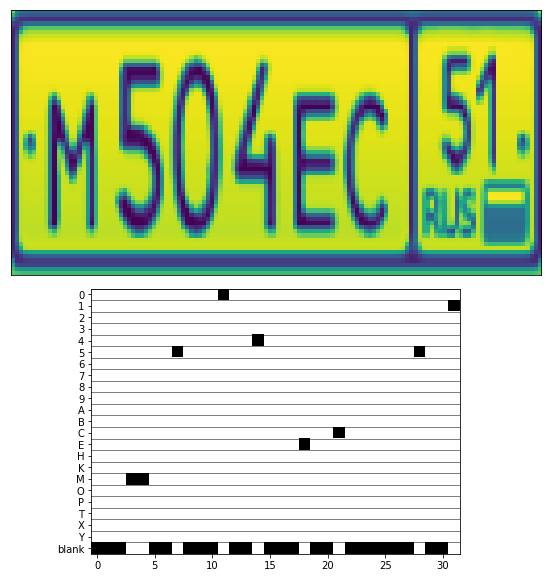

In [121]:
for inp_value, _ in tiger.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.05)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Pred: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_label('Img')
        ax1.imshow(img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break